In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [61]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [62]:
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.experimental import enable_iterative_imputer  
from sklearn.impute import IterativeImputer

In [63]:
from sklearn.metrics import confusion_matrix, classification_report, log_loss

In [64]:
import category_encoders as ce

In [65]:
import warnings
warnings.filterwarnings("ignore")

In [66]:
pd.set_option('display.max_columns', 120)

In [67]:
tr = pd.read_csv('train.csv')
ts = pd.read_csv('test.csv')

In [68]:
drop_list = ['importance1', 'importance2', 'score1', 'score2', 'xg1', 'xg2', 
             'nsxg1', 'nsxg2', 'adj_score1', 'adj_score2', 'date', 'league']

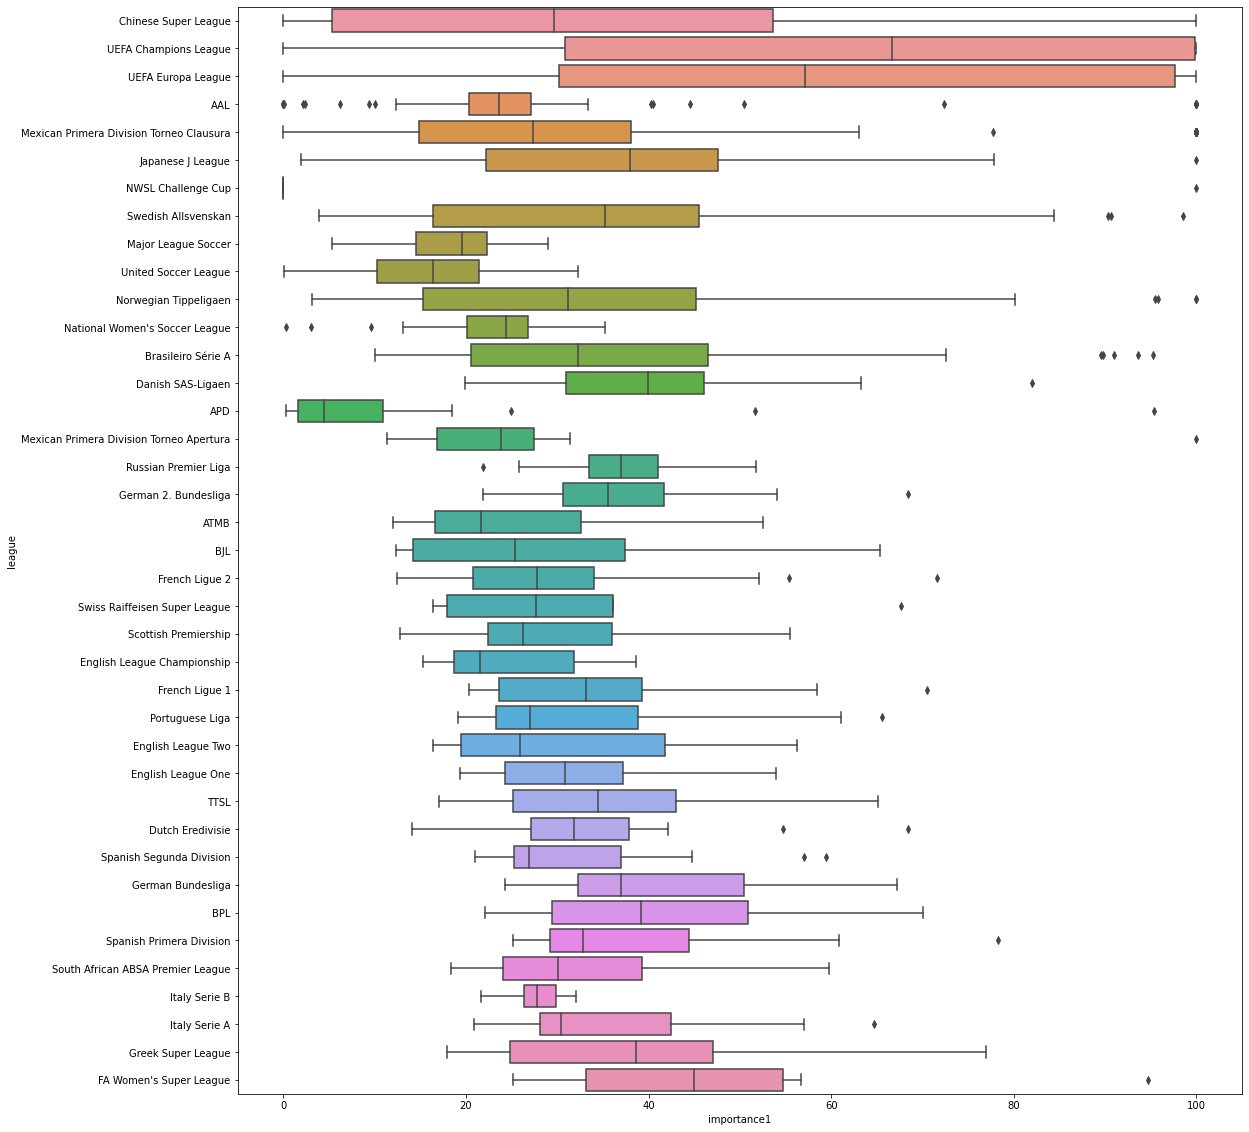

In [69]:
plt.figure(figsize=(18, 20))
sns.boxplot(y='league', x='importance1', data=tr)
plt.show()

In [84]:
df = tr.copy()#drop(columns = ['date', 'league'])
df['month'] = tr['date'].apply(lambda x: int(x[-5:-3]))
df['spi_diff'] = df.SPI1 - df.SPI2
df['score_diff'] = df.proj_score1 - df.proj_score2
df['score_diff'] = np.exp(df.score_diff)

<AxesSubplot:xlabel='score_diff'>

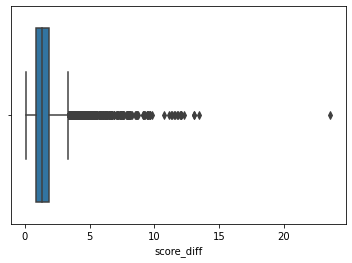

In [85]:
sns.boxplot(df.score_diff)

In [86]:
y = df.Outcome
transformer = ce.GLMMEncoder()
X = df.drop(columns = drop_list)
X['total_spi'] = X.SPI1 + X.SPI2
X['projected_goals'] = X.proj_score1 + X.proj_score2
X = transformer.fit_transform(X.drop('Outcome', axis=1), y)
X_cols = X.columns.to_list()

In [87]:
X.sample(10)

,season,league_id,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,month,spi_diff,score_diff,total_spi,projected_goals
1100,2021,1947,-0.284393,0.807054,27.05,17.64,1.55,0.94,5,9.41,1.840431,44.69,2.49
5741,2021,2417,-2.509962,-3.106683,25.30,42.00,1.05,1.65,10,-16.70,0.548812,67.30,2.70
146,2019,1979,-0.633057,1.263646,26.77,37.99,1.24,1.26,7,-11.22,0.980199,64.76,2.50
6642,2021,2412,0.124133,-3.322645,43.20,57.61,1.16,1.58,11,-14.41,0.657047,100.81,2.74
4080,2021,1856,0.328715,-2.472599,31.05,43.19,1.29,1.64,9,-12.14,0.704688,74.24,2.93
2161,2021,2105,-1.263250,2.677021,42.54,41.01,1.43,1.05,8,1.53,1.462285,83.55,2.48
5779,2021,1827,0.328715,-0.585286,39.32,40.98,1.49,1.41,10,-1.66,1.083287,80.30,2.90
607,2020,1948,-1.137202,-0.102732,23.53,25.57,1.52,1.35,2,-2.04,1.185305,49.10,2.87
2603,2021,1871,0.917675,2.237602,30.54,23.58,1.61,1.05,8,6.96,1.750673,54.12,2.66
1151,2021,2160,-2.987502,-0.548606,9.27,16.19,1.24,1.49,5,-6.92,0.778801,25.46,2.73


In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

In [89]:
grd_model = GradientBoostingClassifier().fit(X_train, y_train)
grd_model.score(X_test, y_test)

0.99892530897367

In [90]:
print (classification_report(y_test, grd_model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       593
           1       1.00      1.00      1.00      1268

    accuracy                           1.00      1861
   macro avg       1.00      1.00      1.00      1861
weighted avg       1.00      1.00      1.00      1861



In [91]:
pd.DataFrame(confusion_matrix(y_test, grd_model.predict(X_test)))

,0,1
0,592,1
1,1,1267


In [92]:
log_loss(y_test, grd_model.predict_proba(X_test))

0.00457524969588739

In [93]:
grd_model

GradientBoostingClassifier()

In [94]:
np.round(grd_model.feature_importances_, 3)

array([0.   , 0.001, 0.002, 0.002, 0.   , 0.001, 0.   , 0.   , 0.001,
       0.   , 0.993, 0.   , 0.   ])

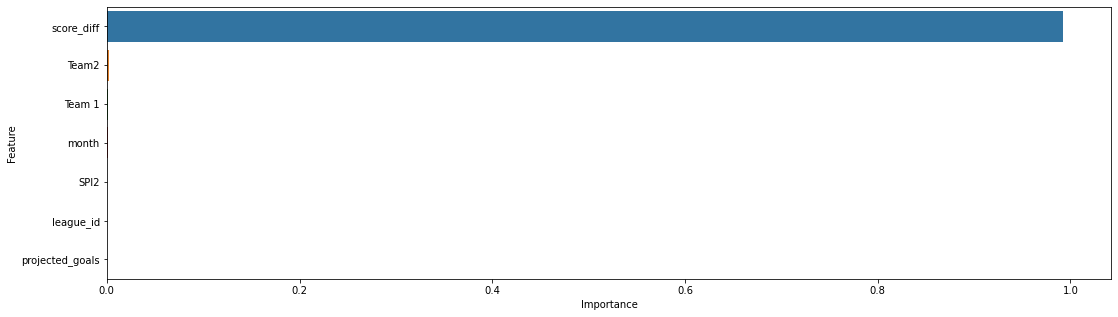

In [290]:
plt.figure(figsize=(18, 5))
df_importance = pd.DataFrame(grd_model.feature_importances_, columns = ['Importance'])
df_importance['Feature'] = X_cols
df_importance.sort_values(by='Importance', ascending=False, inplace=True)
sns.barplot(x='Importance', y='Feature', data=df_importance.head(7))
plt.show()

In [233]:
models = [ ('grd', GradientBoostingClassifier()) , 
           ('rf', RandomForestClassifier())]
vot_model = VotingClassifier(models, voting='soft').fit(X_train, y_train)
print (vot_model.score(X_test, y_test) , log_loss(y_test, vot_model.predict_proba(X_test)))

0.9978506179473401 0.010380578247238734


In [144]:
df_test = ts.drop(columns = drop_list)
#df_test = ts.drop(columns = ['date', 'league'])
df_test['month'] = ts['date'].apply(lambda x: int(x[-5:-3]))
df_test['spi_diff'] = df_test.SPI1 - df_test.SPI2
df_test['score_diff'] = df_test.proj_score1 - df_test.proj_score2
df_test['total_spi'] = df_test.SPI1 + df_test.SPI2
df_test['projected_goals'] = df_test.proj_score1 + df_test.proj_score2

X_predict = transformer.transform(df_test)
#X_predict = pd.DataFrame(imputer.transform(X_predict), columns = X_cols)

In [145]:
predictions = pd.DataFrame(grd_model.predict_proba(X_predict))
predictions.to_csv('prediction.csv', index=False, header=True)

In [25]:
predictions.shape

(4008, 1)

In [26]:
from pycaret.classification import compare_models, setup, create_model, tune_model
from pycaret.classification import predict_model, blend_models, ensemble_model, automl

In [122]:
X_train.head()

,season,league_id,Team 1,Team2,SPI1,SPI2,proj_score1,proj_score2,month,spi_diff,score_diff,total_spi,projected_goals
2307,2021,1843,-0.022116,0.782093,66.61,57.82,1.58,0.93,8,8.79,0.65,124.43,2.51
6709,2021,2411,1.786745,-0.755937,91.64,74.06,2.33,0.89,11,17.58,1.44,165.70,3.22
3397,2021,2160,0.872239,0.627498,15.65,14.43,1.72,1.22,9,1.22,0.50,30.08,2.94
305,2020,1820,1.064018,1.464924,57.68,56.76,1.49,1.21,10,0.92,0.28,114.44,2.70
4463,2021,2413,1.640787,2.301532,31.16,12.19,2.02,0.75,9,18.97,1.27,43.35,2.77


In [132]:
pyc_model = setup(pd.concat([X_train, y_train], axis=1), target='Outcome', numeric_features=['season', 'month'])

,Description,Value
0,session_id,6453
1,Target,Outcome
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5582, 14)"
5,Missing Values,False
6,Numeric Features,13
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [133]:
pyc_model

(2307    1
 6709    1
 3397    1
 305     1
 4463    1
        ..
 4236    1
 4545    0
 444     1
 1409    0
 1220    1
 Name: Outcome, Length: 5582, dtype: int64,
 False,
 StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
       season  league_id    Team 1     Team2       SPI1       SPI2  \
 2307  2021.0     1843.0 -0.022116  0.782093  66.610001  57.820000   
 6709  2021.0     2411.0  1.786745 -0.755937  91.639999  74.059998   
 3397  2021.0     2160.0  0.872239  0.627498  15.650000  14.430000   
 305   2020.0     1820.0  1.064018  1.464924  57.680000  56.759998   
 4463  2021.0     2413.0  1.640787  2.301532  31.160000  12.190000   
 ...      ...        ...       ...       ...        ...        ...   
 4236  2021.0     1859.0 -0.131588  2.512674  30.000000  19.860001   
 4545  2021.0     2413.0 -0.349695 -0.746893  15.720000  21.709999   
 444   2020.0     1818.0 -1.404283  1.464924  64.320000  53.790001   
 1409  2020.0     1948.0 -1.137202 -2.928115  20.150000  41.59

In [149]:
top5 = compare_models(n_select = 5) 

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.9969,0.9993,0.9985,0.9970,0.9977,0.9930,0.9930,0.1180
ada,Ada Boost Classifier,0.9964,0.9987,0.9985,0.9963,0.9974,0.9918,0.9918,0.1520
xgboost,Extreme Gradient Boosting,0.9964,0.9994,0.9985,0.9963,0.9974,0.9918,0.9918,0.1970
catboost,CatBoost Classifier,0.9964,0.9993,0.9981,0.9966,0.9974,0.9918,0.9918,5.1170
rf,Random Forest Classifier,0.9962,0.9989,0.9985,0.9959,0.9972,0.9912,0.9912,0.3790
gbc,Gradient Boosting Classifier,0.9959,0.9992,0.9974,0.9966,0.9970,0.9906,0.9907,0.4240
dt,Decision Tree Classifier,0.9949,0.9939,0.9966,0.9959,0.9962,0.9883,0.9883,0.0180
et,Extra Trees Classifier,0.9908,0.9989,0.9936,0.9929,0.9932,0.9789,0.9789,0.3570
lr,Logistic Regression,0.9800,0.9980,0.9872,0.9835,0.9853,0.9542,0.9543,0.8720
nb,Naive Bayes,0.9764,0.9976,0.9736,0.9916,0.9824,0.9467,0.9472,0.0140


In [151]:
blender = blend_models(estimator_list = top5) 

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9949,0.9984,0.9925,1.0000,0.9962,0.9883,0.9884
2,0.9974,1.0000,1.0000,0.9962,0.9981,0.9941,0.9941
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.9974,1.0000,0.9962,1.0000,0.9981,0.9942,0.9942
5,0.9949,1.0000,1.0000,0.9925,0.9962,0.9882,0.9883
6,0.9923,0.9991,1.0000,0.9888,0.9944,0.9823,0.9825
7,0.9949,0.9942,0.9962,0.9962,0.9962,0.9882,0.9882
8,0.9949,0.9997,1.0000,0.9925,0.9962,0.9882,0.9883
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [160]:
pd.DataFrame(confusion_matrix(y_test, blender.predict(X_test)))

,0,1
0,589,4
1,2,1266


In [153]:
log_loss(y_test, blender.predict_proba(X_test))

0.08948163006321265

In [161]:
gbc_model = create_model('lightgbm')
gbc_tuned = tune_model(gbc_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
1,0.9949,0.9996,0.9925,1.0000,0.9962,0.9883,0.9884
2,0.9949,1.0000,1.0000,0.9925,0.9962,0.9882,0.9883
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
5,0.9949,1.0000,1.0000,0.9925,0.9962,0.9882,0.9883
6,0.9923,0.9978,1.0000,0.9888,0.9944,0.9823,0.9825
7,0.9949,0.9945,1.0000,0.9925,0.9962,0.9882,0.9882
8,0.9974,0.9980,1.0000,0.9962,0.9981,0.9941,0.9941
9,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


In [135]:
gbc_model.feature_importances_

array([0.0021212 , 0.00574169, 0.00823901, 0.00568578, 0.00364206,
       0.00346686, 0.00767409, 0.00306634, 0.00919508, 0.0036445 ,
       0.9429431 , 0.00187863, 0.00270162], dtype=float32)

In [163]:
pd.DataFrame(confusion_matrix(y_test, gbc_tuned.predict(X_test)))

,0,1
0,588,5
1,2,1266


In [164]:
log_loss(y_test, grd_model.predict_proba(X_test))

0.004536556227932581

In [166]:
log_loss(y_test, gbc_tuned.predict_proba(X_test))

0.010153278870699747

In [33]:
predictions = pd.DataFrame(blender.predict_proba(X_predict)[:, 1])

In [34]:
predictions.to_csv('prediction.csv', index=False, header=True)